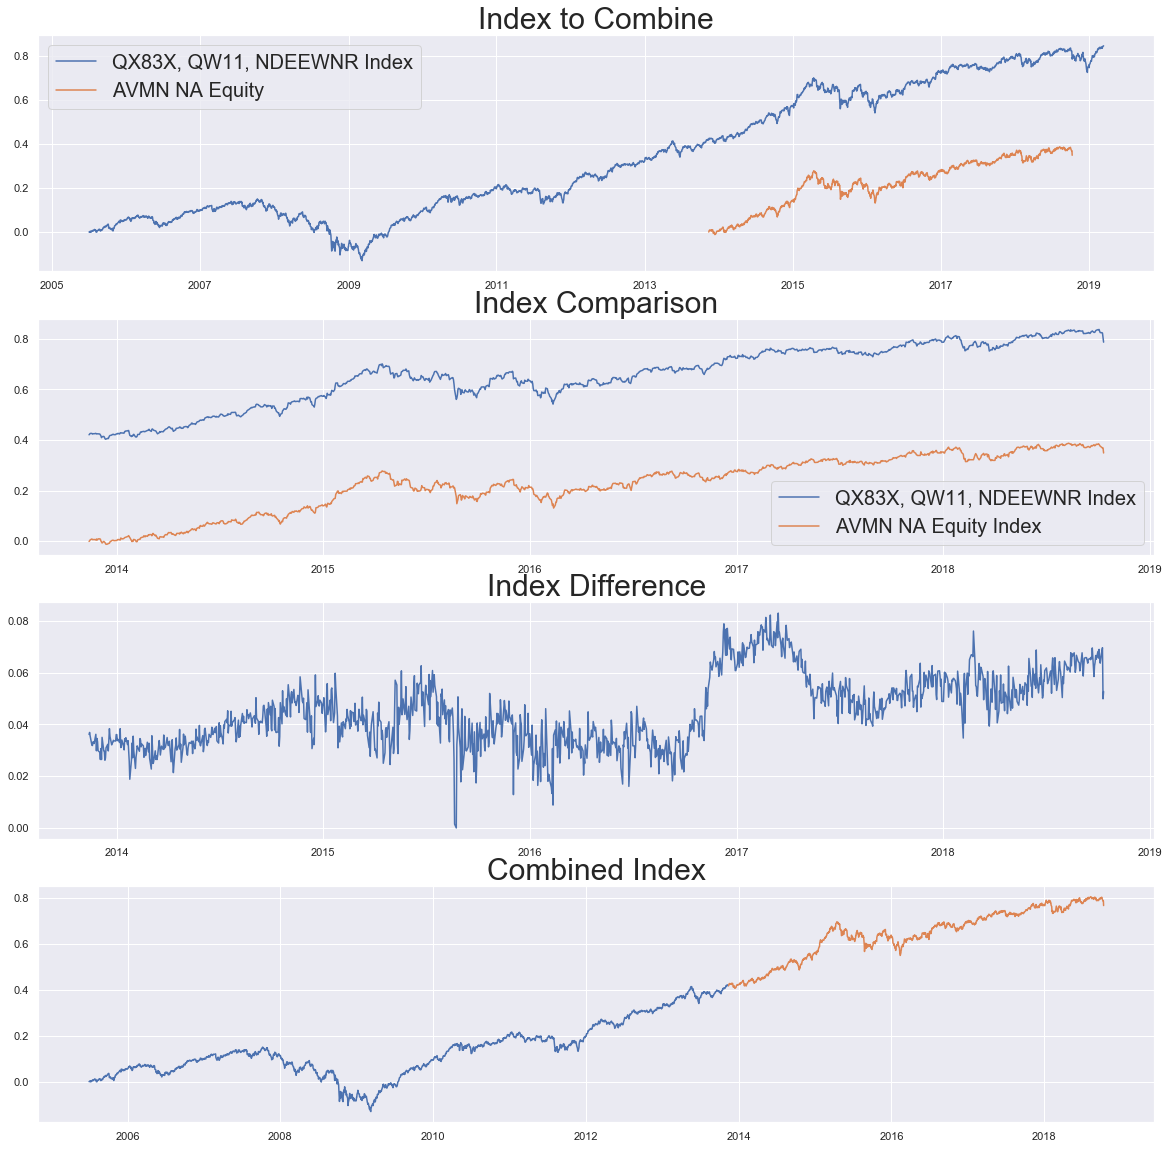

In [88]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

_figsize = (20,20)

# Date parser
dateparse = lambda dates: [pd.datetime.strptime(d, '%d/%m/%Y') for d in dates]

def load_timeserie(filename):
    df = pd.read_csv(filename, skiprows=6, parse_dates=True, date_parser=dateparse, index_col='Dates').dropna()
    return df

def get_daily_return(df):
    df['Pct Change'] = df.pct_change().fillna(0)
    df['Total Return'] = 0
    df.iloc[0, -1] = 1
    for row in range(1, df.shape[0]):
        df.iloc[row, -1] = df.iloc[row-1, -1] * (1+df.iloc[row, -2])
    df.iloc[:,-1] = df.iloc[:,-1] - 1
    return df

def scale(data):
    return (data - data.min()) * 1.0 / (data.max() - data.min())

def get_difference(df1, df2):
    df = pd.concat([df1, df2], axis=1).dropna()
    df['Index Difference'] = (df.iloc[:,0] - df.iloc[:,1])
    df['Index Difference'] = df['Index Difference'] - df['Index Difference'].min()
    return df

def reduce_timeserie(df, max_date):
    return df[:max_date]

# Load time series
agg_avmn = pd.read_excel('./Data/AVMN_Agg.xlsx', index_col = 'Dates')
avmn = load_timeserie('./Data/AVMN_NA_Equity.csv')

# Compute daily returns
avmn = get_daily_return(avmn)
avmn_diff = get_difference(agg_avmn, avmn['Total Return'])

# Combined time serie
new_avmn = agg_avmn.loc[:avmn.index[-1]].copy()
new_avmn.columns = ['Total Return']
offset = new_avmn.iloc[new_avmn.index.get_loc(avmn.index[0])-1]
new_avmn.loc[avmn.index[0]:avmn.index[-1], 'Total Return'] = avmn.loc[avmn.index[0]:avmn.index[-1], 'Total Return'].tolist() + offset[0]
new_avmn.to_csv('./Data/AVMN Combined.csv')

# Plot time series
fig, ax = plt.subplots(4,1, figsize=_figsize)
ax[0].plot(agg_avmn)
ax[0].plot(avmn['Total Return'])
ax[0].legend(['QX83X, QW11, NDEEWNR Index', 'AVMN NA Equity'], fontsize=20)
ax[0].set_title('Index to Combine', fontsize=30)

ax[1].plot(avmn_diff.iloc[:,:2])
ax[1].legend(['QX83X, QW11, NDEEWNR Index', 'AVMN NA Equity Index'], fontsize=20)
ax[1].set_title('Index Comparison', fontsize=30)

ax[2].plot(avmn_diff.iloc[:,2])
ax[2].set_title('Index Difference', fontsize=30)

ax[3].plot(new_avmn[:avmn.index[0]])
ax[3].plot(new_avmn[avmn.index[0]:])
ax[3].set_title('Combined Index', fontsize=30)
plt.savefig('./Figures/AVMN_Combined.png')
plt.show()
